### MIS 284N Assingment 1

Group Member: Hung-Yen Chen, ChunHsiang Chang, Pooshan Shah, Guanhua Zhang and Shan Qin

### Part A
#### A1

In [1]:
import nltk
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

raw_data = pd.read_csv('all/Train_rev1/Train_rev1.csv')
job = raw_data.sample(n=2500, random_state=99)

In [2]:
from nltk import word_tokenize
from string import punctuation

## Transfrom all words into lowercase and drop the punctuation
def preprocess(x):
    lowercase= x.lower()
    for p in punctuation:
        lowercase = lowercase.replace(p,'')
    return lowercase

token = job['FullDescription'].map(preprocess).map(word_tokenize)
token = token.reset_index()['FullDescription']
pos_tagging = token.map(nltk.pos_tag)

In [3]:
tags = []

def pos_series(x):
    for word, pos in x:
        tags.append(pos)
pos_tagging.map(pos_series)
pd.Series(tags).value_counts()[:5]

NN     156816
JJ      69903
IN      65426
NNS     50777
DT      50574
dtype: int64

As we can see, NN (Noun, singular or mass) is the most common POS in the job descriptions. Second most common POS is JJ (Adjective), followed by IN (Preposition or subordinating conjunction), NNS (Noun, plural) and DT (Determiner). 

#### Excluding Stopwords

In [4]:
from nltk.corpus import stopwords 

stop_words = set(stopwords.words('english'))

filtered_sentence = [] 

def remove_stopwords(x):
    for w in x: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
token.map(remove_stopwords)
pos_tagging_without_stopwords = nltk.pos_tag(filtered_sentence)

tags_without_stopwords = []

for word, pos in pos_tagging_without_stopwords:
    tags_without_stopwords.append(pos)
pd.Series(tags_without_stopwords).value_counts()[:5]

NN     150812
JJ      72987
NNS     50230
VBG     25524
VBP     16890
dtype: int64

After removing stop words, NN (Noun, singular or mass) is still the most common POS in the job descriptions. JJ (Adjective) is still the second most common POS. NNS (Noun, plural) becomes the third most common POS. VBG (Verb, gerund or present participle) and VBP (Verb, non-3rd person singular present) become fourth and fifth common among all POS. 

#### A2

In [5]:
word_list = []

def pos_series(x):
    for word, pos in x:
        word_list.append(word)
pos_tagging.map(pos_series)

word_counts = pd.Series(word_list).value_counts()
word_rank = word_counts.rank(method='max',ascending=False)
top_100_words = word_counts[:100]

In [6]:
import math

top_100_words = top_100_words.reset_index()
top_100_words.columns = ['words','freq']
top_100_words['rank'] = top_100_words['freq'].rank(method='max',ascending=False)
top_100_words['log_freq'] = top_100_words['freq'].map(math.log)
top_100_words['log_rank'] = top_100_words['rank'].map(math.log)
top_100_words['norm_log_freq'] = (top_100_words['freq'] / (100*min(top_100_words['freq']))).map(math.log)

Text(0,0.5,'log(Freq)')

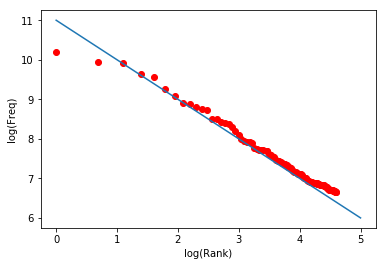

In [7]:
plt.plot(top_100_words['log_rank'],top_100_words['log_freq'],'ro')
plt.plot([0,5],[11,6])
plt.xlabel('log(Rank)')
plt.ylabel('log(Freq)')

It seems like our data do support Zipf's law.

In [9]:
from statsmodels.formula.api import ols
formula = 'log_rank ~ 0 + norm_log_freq'
results = ols(formula, top_100_words).fit()
hypotheses = 'norm_log_freq = -1'
t_test = results.t_test(hypotheses)
print(t_test)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.9677      0.004      8.692      0.000      -0.975      -0.960


After using t test, we have 95% of the confidence level to say the coefficient is not -1. Thus, our data do not support Zipf's law. 

#### A3

In [15]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [16]:
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
l = []
for word, tag in pos_tagging_without_stopwords:
    wntag = get_wordnet_pos(tag)
    if wntag is None:
        lemma = lemmatizer.lemmatize(word)
        l.append(lemma)
    else:
        lemma = lemmatizer.lemmatize(word, pos=wntag) 
        l.append(lemma)

pd.Series(l).value_counts()[:10]

work          5187
experience    4863
role          3133
team          3052
client        2994
business      2864
service       2438
skill         2320
sale          2209
within        2181
dtype: int64

### Part B

#### B1 (model using numeric columns)

In [38]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import sklearn
from patsy import dmatrices
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/chunhsiangchang/anaconda2/envs/Python3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [39]:
train_o = pd.read_csv("all/Train_rev1.csv")

In [40]:
train = train_o.sample(n = 2500, random_state = 1)

In [41]:
test = train_o.sample(n = 2500, random_state = 2)

In [42]:
train["ContractType"].value_counts()

full_time    585
part_time     92
Name: ContractType, dtype: int64

In [43]:
train["ContractTime"].value_counts()

permanent    1520
contract      286
Name: ContractTime, dtype: int64

In [44]:
train["Category"].value_counts()[:10]

IT Jobs                             356
Engineering Jobs                    254
Accounting & Finance Jobs           219
Healthcare & Nursing Jobs           212
Other/General Jobs                  180
Sales Jobs                          170
Teaching Jobs                       154
Hospitality & Catering Jobs         113
PR, Advertising & Marketing Jobs     93
Trade & Construction Jobs            86
Name: Category, dtype: int64

In [45]:
train["LocationNormalized"].value_counts()[:10]

UK                   443
London               325
South East London    103
The City              68
Birmingham            40
Leeds                 33
Central London        30
Manchester            29
Surrey                24
Leicester             23
Name: LocationNormalized, dtype: int64

In [46]:
#train["ContractType"].value_counts()

#train["ContractTime"].value_counts()

#train["Category"].value_counts()

#train["LocationNormalized"].value_counts()

In [47]:
train_num = train[["ContractType", "ContractTime","Category", "LocationNormalized"]].copy()
test_num = train[["ContractType", "ContractTime","Category", "LocationNormalized"]].copy()

In [48]:
London_area = ["London", "South East London", "Central London"]

In [49]:
train_num["LocationNormalized"] = train_num["LocationNormalized"].map(lambda x: "London_area" if x in London_area else "Others")
test_num["LocationNormalized"] = test_num["LocationNormalized"].map(lambda x: "London_area" if x in London_area else "Others")

In [50]:
train_num[:5]

,ContractType,ContractTime,Category,LocationNormalized
179687,NaN,permanent,IT Jobs,London_area
18497,NaN,NaN,Hospitality & Catering Jobs,London_area
86382,NaN,permanent,Legal Jobs,Others
12805,NaN,permanent,Retail Jobs,Others
203497,NaN,permanent,IT Jobs,Others


In [51]:
high_cut = train_o["SalaryNormalized"].describe()["75%"]

In [52]:
train_num_y = train["SalaryNormalized"].map(lambda x : "high" if x >= high_cut else "low")
test_num_y = test["SalaryNormalized"].map(lambda x : "high" if x >= high_cut else "low")

In [53]:
#train_num.fillna("missing", inplace = True)
#test_num.fillna("missing", inplace = True)

In [54]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
#gnb = GaussianNB()
gnb = MultinomialNB()

In [55]:
train_num_d = pd.get_dummies(train_num)
test_num_d = pd.get_dummies(test_num)

In [56]:
train_num_d[:3]

,ContractType_full_time,ContractType_part_time,ContractTime_contract,ContractTime_permanent,Category_Accounting & Finance Jobs,Category_Admin Jobs,Category_Charity & Voluntary Jobs,Category_Consultancy Jobs,Category_Creative & Design Jobs,Category_Customer Services Jobs,...,Category_Property Jobs,Category_Retail Jobs,Category_Sales Jobs,Category_Scientific & QA Jobs,Category_Social work Jobs,Category_Teaching Jobs,Category_Trade & Construction Jobs,Category_Travel Jobs,LocationNormalized_London_area,LocationNormalized_Others
179687,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
18497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
86382,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [96]:
type(train_num_d)

pandas.core.frame.DataFrame

In [102]:
train_num_d.loc[179687]

ContractType_full_time                       0
ContractType_part_time                       0
ContractTime_contract                        0
ContractTime_permanent                       1
Category_Accounting & Finance Jobs           0
Category_Admin Jobs                          0
Category_Charity & Voluntary Jobs            0
Category_Consultancy Jobs                    0
Category_Creative & Design Jobs              0
Category_Customer Services Jobs              0
Category_Domestic help & Cleaning Jobs       0
Category_Energy, Oil & Gas Jobs              0
Category_Engineering Jobs                    0
Category_Graduate Jobs                       0
Category_HR & Recruitment Jobs               0
Category_Healthcare & Nursing Jobs           0
Category_Hospitality & Catering Jobs         0
Category_IT Jobs                             1
Category_Legal Jobs                          0
Category_Logistics & Warehouse Jobs          0
Category_Maintenance Jobs                    0
Category_Manu

In [57]:
classifier = gnb.fit(train_num_d , train_num_y)

In [58]:
y_pred_train =classifier.predict(train_num_d)
y_pred_test =classifier.predict(test_num_d)

In [59]:
from sklearn import metrics
print(metrics.accuracy_score(train_num_y, y_pred_train))

0.7844


In [60]:
print(metrics.accuracy_score(test_num_y, y_pred_test))

0.7076


In [61]:
print(metrics.confusion_matrix(test_num_y, y_pred_test, labels=("high", "low")))

[[  49  558]
 [ 173 1720]]


This model's training accuracy is 78.44%, and the test accuracy is 70.76%. 

#### B2 (model using text as the only predictor)

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [63]:
import string

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return tokens

In [64]:
#train["FullDescription"] = train["FullDescription"].map(tokenize)

#test["FullDescription"] = test["FullDescription"].map(tokenize)

In [65]:
vectorizer = TfidfVectorizer(
 tokenizer=tokenize,
 use_idf = False,
 stop_words='english')

In [66]:
train_adjusted = train.copy()
train_adjusted["SalaryNormalized"] = train["SalaryNormalized"].map(lambda x : "high" if x >= high_cut else "low")

In [67]:
high_used = train_adjusted[train_adjusted["SalaryNormalized"] == "high"]

In [68]:
low_observation = train_adjusted[train_adjusted["SalaryNormalized"] == "low"]
low_used = low_observation.sample(len(high_used), random_state = 1)

In [69]:
train_resampled = pd.concat([high_used, low_used])

In [70]:
X_train = vectorizer.fit_transform(train_resampled["FullDescription"])
X_test = vectorizer.transform(test["FullDescription"])

In [72]:
Y_train = train_resampled["SalaryNormalized"]
Y_test = test["SalaryNormalized"].map(lambda x : "high" if x >= high_cut else "low")

In [73]:
X_train_d = X_train.todense()

X_test_d = X_test.todense()

In [74]:
classifier_2 = gnb.fit(X_train_d, Y_train)

In [75]:
y_pred_2 =classifier_2.predict(X_train_d)

In [77]:
print(metrics.accuracy_score(Y_train, y_pred_2))

0.8552412645590682


In [78]:
y_pred_t_2 = classifier_2.predict(X_test_d)

In [79]:
print(metrics.accuracy_score(Y_test, y_pred_t_2))

0.7428


In [80]:
print(metrics.confusion_matrix(Y_test, y_pred_t_2, labels=("high", "low")))

[[ 519   88]
 [ 555 1338]]


This model's training accuracy is 85.52%, and the test accuracy is 74.28%. 

In [81]:
from operator import itemgetter

In [82]:
N = 10
vocabulary = np.array([t for t, i in sorted(vectorizer.vocabulary_.items(), key=itemgetter(1))])

topN = np.argsort(classifier_2.coef_[0])[-N:]
print("\nThe top %d most informative features for topic code %s: \n%s" % (N, "high", " ,".join(vocabulary[topN])))


The top 10 most informative features for topic code high: 
looking ,client ,sales ,skills ,business ,working ,team ,work ,role ,experience


In [83]:
topN = np.argsort(classifier_2.coef_[0])[:N]
print("\nThe top %d most informative features for topic code %s: \n%s" % (N, "low", " ,".join(vocabulary[topN])))


The top 10 most informative features for topic code low: 
�negotiable ,fpr ,fpml ,fpgapld ,fpga ,fox ,foundationwinformshands ,foundationqualificationsmicrosoft ,fosters ,fpsoflngtopside


In [104]:
X_train_combine = np.concatenate((np.array(train_num_d.loc[train_resampled.index.values]), X_train_d), axis=1)
X_test_combine = np.concatenate((np.array(test_num_d), X_test_d), axis=1)

In [105]:
classifier_3 = gnb.fit(X_train_combine, Y_train)

In [106]:
y_pred_3 =classifier_3.predict(X_train_combine)

In [107]:
print(metrics.accuracy_score(Y_train, y_pred_3))

0.8036605657237936


In [108]:
y_pred_t_3 = classifier_3.predict(X_test_combine)

In [109]:
print(metrics.accuracy_score(Y_test, y_pred_t_3))

0.69


In [110]:
print(metrics.confusion_matrix(Y_test, y_pred_t_3, labels=("high", "low")))

[[ 390  217]
 [ 558 1335]]


This model's training accuracy is 80.37%, and the test accuracy is 69%. 